### [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=3356s)

### [chatGPT-4, released on 2023-03-14, has 1 trillion paramaters and cost $100 million to train](https://en.wikipedia.org/wiki/GPT-4)

In [271]:
import math, random, torch
import numpy as np
# import random
import matplotlib.pyplot as plt
%matplotlib inline

In [272]:
def plot_losses(losses):
  # import matplotlib.pyplot as plt
  
  # Create a list of iterations
  iterations = range(len(losses))

  # Plot the loss as a function of iteration
  plt.plot(iterations, losses)

  # Add a title to the plot
  plt.title('Loss vs. Iteration')

  # Add labels to the x-axis and y-axis
  plt.xlabel('Iteration')
  plt.ylabel('Loss')

In [273]:
def print_parameters(parameters):
  # number of parameters (e.g sum (weights + bias to each neuron and output))
  # MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
  print(f'Number of parameters in MLP(2, [3, 3, 1]): {len(parameters())}\n')

  # print first 5 parameters
  for i, v in enumerate(parameters()):
    if i < 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')
  
  print('---')

  # print last 5 parameters   
  for i, v in enumerate(parameters()):
    if i >= len(parameters()) - 5:
      print(f'i: {i:>2}, {v.data:>14.10f}')

In [274]:
def get_wt_n_b_mats(layers, verbose=False):
  ''' Get neuron's weights and bias for each layer.
  Inputs: If n = MLP(2, [3, 3, 1]), input is n.layers.

  return: two lists of np.arrays. The first list is weight matrix for each layer
          The second list is the bias matrix for each layer 
  '''
  layer_cnt = len(layers)  # number of layers
  w_mats = []  # list of weights matrix for each layer 
  b_mats = []  # list of bias matrix for each layer
  if verbose:
    print(f'layer_cnt: {layer_cnt}\n')
  for i, layer in enumerate(layers):
      neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer
      if verbose: 
        print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

        print('----')
      b_mat = []  # accumulate neuon's bias for each row     
      for j, neuron in enumerate(layer.neurons):
          if verbose:
            print(f'layer: {i}, neuron {j}')
          b = neuron.b.data  # bias of neuron 
          w_row = []  # accumulate neuon's weights for each row
          b_row = []  # accumulate neuon's bias for each row
          for k, w in enumerate(neuron.w):
              w_row.append(w.data)
              if verbose:
                print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
          if j == 0:            
              w_mat = np.array([w_row])
          else:
              w_mat = np.vstack((w_mat, w_row))
          
          b_mat.append(b)
          if verbose:
            print(f'b:  {b:10.7f}\n')
            print(f'b:  {b:10.7f}')        
            print(f'b_mat:  {b_mat}\n')
      w_mats.append(w_mat)  
      b_mats.append(np.array([b_mat]))        
      if verbose:
          print('------')

  zipped_w_n_b = zip(w_mats, b_mats)
  if verbose:
    for i, w_n_b in enumerate(zipped_w_n_b):
      print(f'layer: {i}')  # 1st layer is 0    
      print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
      print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  

  return w_mats, b_mats

### Micrograd Classes and Functions<br>* limited to neural network with one output, e.g. MLP(2, [3, 1])<br>* neural network with multiple outputs, e.g.  MLP(2, [3, 3]), will produce errors in backward pass 

In [275]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [276]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    # https://en.wikipedia.org/wiki/Hyperbolic_functions
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [277]:
class Neuron:
    
    def __init__(self, nin):
        # random numbers evenly distributed between -1 and 1    
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]  
        self.b = Value(random.uniform(-1,1))

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Neuron(w = {self.w}, b = {self.b})"
######################################################

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        # print(f'w: {self.w}, b: {[self.b]}')
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

#### my add ##########################################
    def __repr__(self) -> str:
        return f"Layer(neurons = {self.neurons})"
######################################################

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params
        return [p for layer in self.layers for p in layer.parameters()]

### Neurons of Human Brain
![](..\karpathy\img\neuron_of_human_brain.png)

### Basic Artificial Neuron Function

<img src="..\karpathy\img\Basic Neuron Function.png">

### Simple Artificial Neural Network<br>* input layer: 2 nodes<br>* hidden layer 1: 3 nodes<br>* hidden layer 2: 3 nodes<br>*  output layer: 1 node<br>* bias and activation of nodes are not shown

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\MLP (2, [3, 3, 1]).png">

### Hidden Layer Matrix Operations<br>* Hidden layer with two inputs (X1, X2), and three neurons (b1, b2, b3)<br>* Two sets of inputs (X1, X2) are shown in different shades of gray<br>* Two sets of outputs (Y1, Y2, Y3) are shown in corresponding shades of gray<br>* Multiple sets of inputs are processed in one matrix operation 

<img src="..\karpathy\img\Hidden Layer Matrix Operations.png">

In [278]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

##### ---- Create Simple Neural Network MLP(2, [3, 3, 1]) ----<br>* 2 input nodes<br>* 3 neurons in hidden layer 1<br>* 3 neurons in hidden layer 2<br>* 1 output node
##### ---- Parameters ----<br>* initialize neuron parameters with random numbers<br>* parameters in layer 1: 3 neurons * (2 inputs + 1 bias) = 9<br>* parameters in layer 2: 3 neurons * (3 neurons + 1 bias) = 12<br>* parameters in layer 3: 1 output * (3 neurons + 1 bias) = 4<br>*  parameters total: 25
##### ---- Inputs ----<br>* 1st set: [2.0, 3.0]<br>* 2nd set: [3.0, -1.0]
##### ---- Desired Output ----<br>* [1.0, -1.0] for all inputs
##### ---- Learning Rate ----<br>* 0.05

In [279]:
# create neural network and initialize weights and biases
n = MLP(2, [3, 3, 1])

# inputs
xs = [
  [2.0, 3.0],
  [3.0, -1.0]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [280]:
if verbose:
  print("Initalize neuron weights and bias with random numbers")
  print_parameters(n.parameters)

Initalize neuron weights and bias with random numbers
Number of parameters in MLP(2, [3, 3, 1]): 25

i:  0,   0.9594606936
i:  1,  -0.2064132580
i:  2,  -0.6543419960
i:  3,  -0.0930072127
i:  4,   0.9062582394
---
i: 20,  -0.5573518384
i: 21,   0.6954353876
i: 22,  -0.5315587348
i: 23,  -0.5156266281
i: 24,  -0.6228903441


In [281]:
# if True:
if verbose:
	# print weights and bias of each layer
	for i, layer in enumerate(n.layers):
		neuron_cnt = len(layer.neurons)  # numbers of neurons in the layer 
		print(f'layer: {i}, neuron_cnt: {neuron_cnt}, layer: {layer}')

layer: 0, neuron_cnt: 3, layer: Layer(neurons = [Neuron(w = [Value(data = 0.9594606936252317), Value(data = -0.20641325804466804)], b = Value(data = -0.654341995999097)), Neuron(w = [Value(data = -0.09300721266459444), Value(data = 0.9062582394415153)], b = Value(data = -0.6312177860520167)), Neuron(w = [Value(data = 0.7659389917117154), Value(data = 0.04917237166555721)], b = Value(data = -0.8649635248197047))])
layer: 1, neuron_cnt: 3, layer: Layer(neurons = [Neuron(w = [Value(data = 0.6248857609168794), Value(data = 0.2611649262148903), Value(data = 0.10736389190511098)], b = Value(data = 0.7851150969174898)), Neuron(w = [Value(data = -0.2392080069525504), Value(data = 0.5818996603367728), Value(data = -0.7804072987649004)], b = Value(data = 0.8967501641990212)), Neuron(w = [Value(data = 0.9172012096912538), Value(data = -0.8143631212810594), Value(data = 0.3158594044258638)], b = Value(data = -0.5573518384397362))])
layer: 2, neuron_cnt: 1, layer: Layer(neurons = [Neuron(w = [Value

##### Transpose inputs xs

In [282]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 2)
xs_mats:
[array([[ 2.,  3.],
       [ 3., -1.]])]

xs_mats_T[0].shape: (2, 2)
xs_mats_T:
[array([[ 2.,  3.],
       [ 3., -1.]])]


##### ---- Start: Manual Calculation of Neural Network Output and Prediction Error ----<br>* calculate neural network output, (a.k.a) Forward Pass<br>* calculate prediction error, (a.k.a) Loss

In [283]:
def forward_pass(layers, verbose=verbose):
  # Get Neural Network's Weights and Biases Matrices
  # w_mats, b_mats = get_wt_n_b_mats(n.layers, verbose=verbose)
  w_mats, b_mats = get_wt_n_b_mats(layers, verbose=verbose)

  # Calculate Neural Network Output and Loss with Matrix Multiplication
  for layer in range(len(layers)):
    if layer == 0:  # first layer, use given inputs xs as inputs
      input = xs_mats_T[layer]
    else:  # after first layer, use outputs from preceding layers as inputs
      input = output

    weights = w_mats[layer]
    bias = np.transpose(b_mats[layer])

    weights_x_input = np.matmul(weights, input)
    weights_x_input_plus_bias = weights_x_input + bias

    # output = np.tanh(np.matmul(weights, input) + bias)
    output = np.tanh(weights_x_input_plus_bias)

    print(f'{"-"*50}')
    print(f'Calculate Output of Layer: {layer}')    
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_+_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')    

    # print(f'output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    
    print(f'Layer {layer} Output = tanh(weights_x_inputs_+_bias) {output.shape}:\n{output}\n')    

  yout = output[0]
  err_sq = ((yout - ys)**2)
  loss_sum = err_sq.sum()
  loss_mean = err_sq.mean()

  print(f'-- Manual calculation results of neural network output and prediction error --')
  print(f'yout:           {yout}')   
  print(f'desired output: {ys}')   
  print(f'err_sq:         {err_sq}')
  print(f'loss_mean:      {loss_mean}')
  print(f'loss_sum:       {loss_sum}')

  return yout, err_sq, loss_sum, loss_mean, w_mats, b_mats


##### Manual calculation results of neural network output and prediction error 

In [284]:
yout, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

layer_cnt: 3

layer: 0, neuron_cnt: 3
----
layer: 0, neuron 0
w0:  0.9594607,   w0.grad:  0.0000000
w1: -0.2064133,   w1.grad:  0.0000000
b:  -0.6543420

b:  -0.6543420
b_mat:  [-0.654341995999097]

layer: 0, neuron 1
w0: -0.0930072,   w0.grad:  0.0000000
w1:  0.9062582,   w1.grad:  0.0000000
b:  -0.6312178

b:  -0.6312178
b_mat:  [-0.654341995999097, -0.6312177860520167]

layer: 0, neuron 2
w0:  0.7659390,   w0.grad:  0.0000000
w1:  0.0491724,   w1.grad:  0.0000000
b:  -0.8649635

b:  -0.8649635
b_mat:  [-0.654341995999097, -0.6312177860520167, -0.8649635248197047]

------
layer: 1, neuron_cnt: 3
----
layer: 1, neuron 0
w0:  0.6248858,   w0.grad:  0.0000000
w1:  0.2611649,   w1.grad:  0.0000000
w2:  0.1073639,   w2.grad:  0.0000000
b:   0.7851151

b:   0.7851151
b_mat:  [0.7851150969174898]

layer: 1, neuron 1
w0: -0.2392080,   w0.grad:  0.0000000
w1:  0.5818997,   w1.grad:  0.0000000
w2: -0.7804073,   w2.grad:  0.0000000
b:   0.8967502

b:   0.8967502
b_mat:  [0.7851150969174898, 0.8

In [285]:
print(f'-- manual calculation results of neural network output and prediction error --')
print(f'yout:           {yout} <-- neural network output')   
print(f'desired output: {ys}')   
print(f'err_sq:         {err_sq}')
print(f'loss_mean:      {loss_mean}')
print(f'loss_sum:       {loss_sum} <-- sum(prediction_error)^2')


-- manual calculation results of neural network output and prediction error --
yout:           [-0.07120729 -0.20910812] <-- neural network output
desired output: [1.0, -1.0]
err_sq:         [1.14748505 0.62550996]
loss_mean:      0.8864975059441333
loss_sum:       1.7729950118882667 <-- sum(prediction_error)^2


##### ---- End: Manual Calculation of Neural Network Output and Prediction Error ----

##### How Neural Network Learns<br>* calculate changes in prediction errors (loss) w.r.t. changes in each parameter (a.k.a. gradients)<br>* adjust parameters in direction of less loss with gradients<br>* repeat the process 

##### Calculate gradient for parameter W0<br>* increase W0 by small amount, e.g. 0.00001<br>* recalculate output and loss<br>* calculate changes in loss w.r.t. changes in W0

In [286]:
# Increase W1 by h
h = .00001
loss_sum_before = loss_sum
print(f'loss_sum_before:  {loss_sum_before:10.7f} <-- loss_sum before increase W1')
W0_before = n.parameters()[0].data  # W1
print(f'W0_before:        {W0_before:10.7f}')
n.parameters()[0].data += h
W0_after = n.parameters()[0].data
print(f'W0_after:         {W0_after:10.7f}') 
W0_dif = W0_after - W0_before
print(f'W0_dif:           {W0_dif:10.7f} <-- increased W1 by a small amount') 

loss_sum_before:   1.7729950 <-- loss_sum before increase W1
W0_before:         0.9594607
W0_after:          0.9594707
W0_dif:            0.0000100 <-- increased W1 by a small amount


##### Recalculate output and Loss with small changes in W0

In [287]:
yout, err_sq, loss_sum, loss_mean, w_mats, b_mats = forward_pass(n.layers, verbose=verbose)

layer_cnt: 3

layer: 0, neuron_cnt: 3
----
layer: 0, neuron 0
w0:  0.9594707,   w0.grad:  0.0000000
w1: -0.2064133,   w1.grad:  0.0000000
b:  -0.6543420

b:  -0.6543420
b_mat:  [-0.654341995999097]

layer: 0, neuron 1
w0: -0.0930072,   w0.grad:  0.0000000
w1:  0.9062582,   w1.grad:  0.0000000
b:  -0.6312178

b:  -0.6312178
b_mat:  [-0.654341995999097, -0.6312177860520167]

layer: 0, neuron 2
w0:  0.7659390,   w0.grad:  0.0000000
w1:  0.0491724,   w1.grad:  0.0000000
b:  -0.8649635

b:  -0.8649635
b_mat:  [-0.654341995999097, -0.6312177860520167, -0.8649635248197047]

------
layer: 1, neuron_cnt: 3
----
layer: 1, neuron 0
w0:  0.6248858,   w0.grad:  0.0000000
w1:  0.2611649,   w1.grad:  0.0000000
w2:  0.1073639,   w2.grad:  0.0000000
b:   0.7851151

b:   0.7851151
b_mat:  [0.7851150969174898]

layer: 1, neuron 1
w0: -0.2392080,   w0.grad:  0.0000000
w1:  0.5818997,   w1.grad:  0.0000000
w2: -0.7804073,   w2.grad:  0.0000000
b:   0.8967502

b:   0.8967502
b_mat:  [0.7851150969174898, 0.8

In [288]:
loss_sum_after = loss_sum
loss_sum_dif = loss_sum_after - loss_sum_before
W0_grad = loss_sum_dif / W0_dif

# print(f'-- manual forward pass calculation --')
print(f'-- recaluclate neural network output and loss with small change in W1 --')
print(f'yout:             {yout}')   
print(f'desired output:   {ys}')   
print(f'err_sq:           {err_sq}')
print(f'loss_sum_before:  {loss_sum_before}')
print(f'loss_sum_after:   {loss_sum_after}\n')
print(f'loss_sum_dif:     {loss_sum_dif} <-- change in loss_sum')
print(f'W0_dif:           {W0_dif} <-- change in W0')
print(f'W0_grad:          {W0_grad} <-- changes in loss_sum w.r.t. changes in W0, manual calculation')

-- recaluclate neural network output and loss with small change in W1 --
yout:             [-0.07120971 -0.20910802]
desired output:   [1.0, -1.0]
err_sq:           [1.14749024 0.62551012]
loss_sum_before:  1.7729950118882667
loss_sum_after:   1.773000355140478

loss_sum_dif:     5.343252211353899e-06 <-- change in loss_sum
W0_dif:           9.99999999995449e-06 <-- change in W0
W0_grad:          0.5343252211378217 <-- changes in loss_sum w.r.t. changes in W0, manual calculation


##### Calculate output and Loss with Micrograd<br>* change W1 back to initial value<br>* compare manual calculation vs Micrograd 

In [289]:
# change W1 back before Micrograd calculation
n.parameters()[0].data = W0_before

ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
# loss.backward()
err_sq_ = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
err_sq = [l.data for l in err_sq_]
loss_sum = sum(err_sq)
loss_len = len(err_sq)
loss_mean = loss_sum / loss_len

# print(f'-- Micrograd forward pass and backward pass --')
print(f'-- Calculate neural network loss and gradient using Micrograd --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'err_sq:             {err_sq}')
print(f'loss_mean:          {loss_mean}')
print(f'loss_sum:           {loss_sum} <-- loss_sum, Micrograd calculation same as manual calc.')
print(f'W0_before:          {n.parameters()[0].data}')

-- Calculate neural network loss and gradient using Micrograd --
ypred_data:         [-0.07120728576561222, -0.20910812192124742]
ys:                 [1.0, -1.0]
err_sq:             [1.1474850490773303, 0.6255099628109365]
loss_mean:          0.8864975059441333
loss_sum:           1.7729950118882667 <-- loss_sum, Micrograd calculation same as manual calc.
W0_before:          0.9594606936252317


##### Calculate gradients and adjust parameters

In [290]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
print('=== adjust parameters ===')
print(f'  i  parameter before         gradient     learning rate   parameter adjusted')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad

  if i == 0:  
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f} <-- gradient same as manual calc. W0_grad {W0_grad:13.10f}')
  else:
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')    

=== adjust parameters ===
  i  parameter before         gradient     learning rate   parameter adjusted
  0      0.9594606936     0.5343232027           0.05000         0.9327445335 <-- gradient same as manual calc. W0_grad  0.5343252211
  1     -0.2064132580     0.7730386363           0.05000        -0.2450651899
  2     -0.6543419960     0.2645755861           0.05000        -0.6675707753
  3     -0.0930072127    -0.0953319320           0.05000        -0.0882406161
  4      0.9062582394    -0.0740006730           0.05000         0.9099582731
  5     -0.6312177861    -0.0413934910           0.05000        -0.6291481115
  6      0.7659389917    -0.0206604730           0.05000         0.7669720154
  7      0.0491723717    -0.5631010676           0.05000         0.0773274250
  8     -0.8649635248    -0.0587039054           0.05000        -0.8620283295
  9      0.6248857609     0.1287428156           0.05000         0.6184486201
 10      0.2611649262    -0.5552455917           0.05000    

### Improve Prediction with Parameter Iteration 

In [291]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.21155274439245073), Value(data = -0.33589549583944733)]
step: 0, loss: 1.0626838673214096
-------
ypred: [Value(data = 0.3942585472399464), Value(data = -0.43450550048344044)]
step: 1, loss: 0.6867067365753444
-------
ypred: [Value(data = 0.4992562436769442), Value(data = -0.5111376904989755)]
step: 2, loss: 0.48973066714719937
-------
ypred: [Value(data = 0.5667151252790948), Value(data = -0.568107487191547)]
step: 3, loss: 0.3742669252819102
-------
ypred: [Value(data = 0.6142349285893889), Value(data = -0.6112061646411802)]
step: 4, loss: 0.299975336733455
-------
ypred: [Value(data = 0.649857986115634), Value(data = -0.644809269368122)]
step: 5, loss: 0.24875988501380691
-------
ypred: [Value(data = 0.6777576025715396), Value(data = -0.6717652238671461)]
step: 6, loss: 0.21157823096342654
-------
ypred: [Value(data = 0.7003262341184668), Value(data = -0.6939186956712589)]
step: 7, loss: 0.1834901308172034
-------
ypred: [Value(data = 0.7190414293282009), Valu

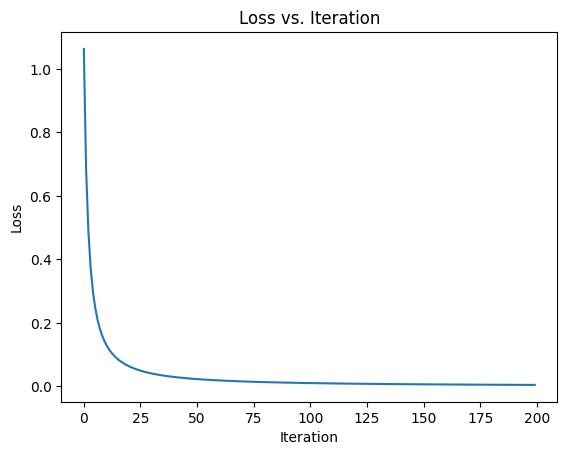

In [292]:
plot_losses(losses)

### Build same model with pyTorch 

In [293]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 0.9306853413581848
Epoch 10 loss: 0.05523651838302612
Epoch 20 loss: 0.00045403599506244063
Epoch 30 loss: 3.204969516445999e-06

Prediction:
tensor([[ 0.9999],
        [-0.9998]])
Loss: 3.766287903772536e-08


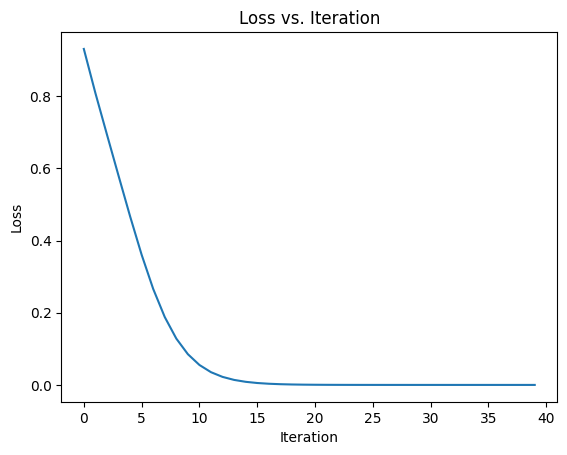

In [294]:
plot_losses(losses)

In [295]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[-0.3102,  0.5688, -0.5803],
        [ 0.0894,  0.2054, -0.5586],
        [-0.2724, -0.0827, -0.2614],
        [-0.2407,  0.1805, -0.2481]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[ 1.6663, -1.7896],
        [ 1.3536, -0.2165],
        [-0.5316, -0.8653],
        [ 0.3080, -1.0267]])

bT,  torch.Size([4, 1]):
tensor([[-0.3755],
        [-0.2527],
        [ 0.4609],
        [ 0.1294]])

w * input + bT,  torch.Size([4, 2]):
tensor([[ 1.2908, -2.1652],
        [ 1.1008, -0.4693],
        [-0.0707, -0.4044],
        [ 0.4374, -0.8972]])

output,  torch.Size([4, 2]):
tensor([[ 0.8593, -0.9740],
        [ 0.8008, -0.4376],
        [-0.0706, -0.3837],
        [ 0.4115, -0.7150]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[-0.2878, -0.533

In [296]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [297]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)

# loss = torch.sum(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9999, -0.9998]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(2.2974e-08)

In [298]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.mean(squared_difference)
loss

tensor([[ 0.9999, -0.9998]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-9.3639e-05,  1.9282e-04]])
squared_difference: tensor([[8.7682e-09, 3.7180e-08]])


tensor(2.2974e-08)

In [299]:
# for item in output.item:
#   print(item)
# type(output)
output.tolist()[0]


[0.9999063611030579, -0.9998071789741516]

In [300]:
import numpy as np

def mse_loss(y_true, y_pred):
  """Calculates the mean squared error loss.

  Args:
    y_true: The ground truth labels.
    y_pred: The predicted labels.

  Returns:
    The mean squared error loss.
  """

  loss = np.mean((y_true - y_pred)**2)
  return loss

def main():
  """Main function."""

  # y_true = np.array([1, 2, 3, 4, 5])
  y_true = np.array([1.0, -1.0])

  # y_pred = np.array([0, 1, 2, 3, 4])
  # y_pred = np.array([0.9997345209121704, -0.9980572462081909])
  y_pred = np.array(output.tolist()[0])  

  loss = mse_loss(y_true, y_pred)
  print(loss)

if __name__ == "__main__":
  main()

2.297409551488272e-08


In [301]:
len(squared_difference)


1

In [302]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(2.2974e-08)

In [303]:
torch.sum((output - torch.tensor(ys))**2)


tensor(4.5948e-08)

##### Check Output and Gradient Calculation with PyTorch

In [304]:
x0 = torch.Tensor([-3.0]).double();      x0.requires_grad = True
x1 = torch.Tensor([0.0]).double();       x1.requires_grad = True
x2 = torch.Tensor([0.5]).double();       x2.requires_grad = True
w0 = torch.Tensor([2.0]).double();       w0.requires_grad = True
w1 = torch.Tensor([1.0]).double();       w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();       w2.requires_grad = True
b = torch.Tensor([4.61862664]).double(); b.requires_grad  = True
n = x0*w0 + x1*w1 + x2*w2 + b
o3 = torch.tanh(n)
o3.backward()

print('---- torch results matched backward pass results ----')
print(f'x0.data.item()  = {x0.data.item():>9.6f}')
print(f'x0.grad.item()  = {x0.grad.item():>9.6f}')
print(f'w0.data.item()  = {w0.data.item():>9.6f}')
print(f'w0.grad.item()  = {w0.grad.item():>9.6f} <-- result matched micrograd')
print('---')
print(f'x1.data.item()  = {x1.data.item():>9.6f}')
print(f'x1.grad.item()  = {x1.grad.item():>9.6f}')
print(f'w1.data.item()  = {w1.data.item():>9.6f}')
print(f'w1.grad.item()  = {w1.grad.item():>9.6f}')
print('---')
print(f'x2.data.item()  = {x2.data.item():>9.6f}')
print(f'x2.grad.item()  = {x2.grad.item():>9.6f}')
print(f'w2.data.item()  = {w2.data.item():>9.6f}')
print(f'w2.grad.item()  = {w2.grad.item():>9.6f}')
print('---')
print(f'out.data.item() = {o3.data.item():>9.6f} <-- result matched micrograd')


---- torch results matched backward pass results ----
x0.data.item()  = -3.000000
x0.grad.item()  =  1.000000
w0.data.item()  =  2.000000
w0.grad.item()  = -1.500000 <-- result matched micrograd
---
x1.data.item()  =  0.000000
x1.grad.item()  =  0.500000
w1.data.item()  =  1.000000
w1.grad.item()  =  0.000000
---
x2.data.item()  =  0.500000
x2.grad.item()  =  0.500000
w2.data.item()  =  1.000000
w2.grad.item()  =  0.250000
---
out.data.item() = -0.707107 <-- result matched micrograd


### Neural Network MLP(3, [4, 4, 1])
    input layer:     3 nodes
    hidden layer 1:  4 nodes
    hidden layer 2:  4 nodes
    output layer:    1 node

<!-- ![Getting Started](..\karpathy\img\Nertual_Network_Neuron.PNG) -->
<img src="..\karpathy\img\neural_network_neuron.PNG">

### Create neural work, initialize weights and biases, define inputs and desired outputs 

In [305]:
# create neural network and initialize weights and biases
n = MLP(3, [4, 4, 1])

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# learning rate (i.e. step size)
learning_rate = 0.05

In [306]:
# number of parameters (e.g sum (weights + bias to each neuron and output))
# MLP(3, [4, 4, 1]) --> 4_neurons(3_inputs + 1_bias) + 4_neurons(4_neurons + 1_bias) + 1_output(4_neurons + 1_bias) = 41_parameters 
print(f'parameters in MLP: {len(n.parameters())}\n')

# print first 5 parameters
for i, v in enumerate(n.parameters()):
  if i < 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')
 
print('---')

# print last 5 parameters   
for i, v in enumerate(n.parameters()):
  if i >= len(n.parameters()) - 5:
    print(f'i: {i:>2}, {v.data:>14.10f}')

parameters in MLP: 41

i:  0,   0.9127026664
i:  1,   0.0431730362
i:  2,  -0.9241878631
i:  3,   0.7266427912
i:  4,   0.7759467967
---
i: 36,  -0.9195648217
i: 37,  -0.1360106546
i: 38,  -0.4362070821
i: 39,  -0.6157402864
i: 40,  -0.1249216480


### ---- Start: Calculate Neural Network Output and Loss with Matrix Multiplication ----

##### Transpose inputs xs

In [307]:
xs_mats = [np.array(xs)]  # convert xs to list of np.arrays
xs_mats_T = []
for mat in xs_mats:
  mat_transpose = np.transpose(mat)
  xs_mats_T.append(mat_transpose)

print(f'xs_mats[0].shape: {xs_mats[0].shape}')
print(f'xs_mats:\n{xs_mats}\n')
print(f'xs_mats_T[0].shape: {xs_mats_T[0].shape}')
print(f'xs_mats_T:\n{xs_mats_T}')

xs_mats[0].shape: (2, 3)
xs_mats:
[array([[ 2. ,  3. , -1. ],
       [ 3. , -1. ,  0.5]])]

xs_mats_T[0].shape: (3, 2)
xs_mats_T:
[array([[ 2. ,  3. ],
       [ 3. , -1. ],
       [-1. ,  0.5]])]


##### Get Neural Network's Weights and Biases Matrices

In [308]:
layer_cnt = len(n.layers)
w_mats = []  # list of weights matrix for each layer 
b_mats = []  # list of bias matrix for each layer
print(f'layer_cnt: {layer_cnt}\n')
for i, layer in enumerate(n.layers):
    neuron_cnt = len(layer.neurons)
    print(f'layer: {i}, neuron_cnt: {neuron_cnt}')

    print('----')
    b_mat = []  # accumulate neuon's bias for each row     
    for j, neuron in enumerate(layer.neurons):
        print(f'layer: {i}, neuron {j}')
        b = neuron.b.data  # bias of neuron 
        w_row = []  # accumulate neuon's weights for each row
        # b_row = []  # accumulate neuon's bias for each row
        for k, w in enumerate(neuron.w):
            w_row.append(w.data)
            print(f'w{k}: {w.data:10.7f},   w{k}.grad: {w.grad:10.7f}')
        if j == 0:            
            w_mat = np.array([w_row])
        else:
            w_mat = np.vstack((w_mat, w_row))
        
        b_mat.append(b)
        print(f'b:  {b:10.7f}\n')
        # print(f'b:  {b:10.7f}')        
        # print(f'b_mat:  {b_mat}\n')
    w_mats.append(w_mat)  
    b_mats.append(np.array([b_mat]))        
    print('------')

layer_cnt: 3

layer: 0, neuron_cnt: 4
----
layer: 0, neuron 0
w0:  0.9127027,   w0.grad:  0.0000000
w1:  0.0431730,   w1.grad:  0.0000000
w2: -0.9241879,   w2.grad:  0.0000000
b:   0.7266428

layer: 0, neuron 1
w0:  0.7759468,   w0.grad:  0.0000000
w1: -0.7816977,   w1.grad:  0.0000000
w2: -0.8746657,   w2.grad:  0.0000000
b:   0.2919712

layer: 0, neuron 2
w0:  0.9783844,   w0.grad:  0.0000000
w1:  0.8445765,   w1.grad:  0.0000000
w2: -0.4438930,   w2.grad:  0.0000000
b:  -0.8634206

layer: 0, neuron 3
w0: -0.3220315,   w0.grad:  0.0000000
w1:  0.5315550,   w1.grad:  0.0000000
w2:  0.0025346,   w2.grad:  0.0000000
b:  -0.3258758

------
layer: 1, neuron_cnt: 4
----
layer: 1, neuron 0
w0: -0.9866332,   w0.grad:  0.0000000
w1:  0.0842178,   w1.grad:  0.0000000
w2:  0.1968115,   w2.grad:  0.0000000
w3: -0.5771002,   w3.grad:  0.0000000
b:   0.3780041

layer: 1, neuron 1
w0:  0.9560823,   w0.grad:  0.0000000
w1: -0.7367079,   w1.grad:  0.0000000
w2:  0.9639842,   w2.grad:  0.0000000
w3: -

##### Print Neural Network's Weights and Biases Matrices

In [309]:
zipped_w_n_b = zip(w_mats, b_mats)
for i, w_n_b in enumerate(zipped_w_n_b):
  print(f'i: {i}')    
  print(f'w_mat{w_n_b[0].shape}:\n{w_n_b[0]}')
  print(f'b_mat{w_n_b[1].shape}:\n{w_n_b[1]}\n')  
    

i: 0
w_mat(4, 3):
[[ 0.91270267  0.04317304 -0.92418786]
 [ 0.7759468  -0.78169775 -0.87466573]
 [ 0.97838442  0.84457648 -0.44389302]
 [-0.3220315   0.53155503  0.00253462]]
b_mat(1, 4):
[[ 0.72664279  0.29197119 -0.86342056 -0.32587576]]

i: 1
w_mat(4, 4):
[[-0.98663324  0.08421784  0.19681153 -0.57710017]
 [ 0.95608228 -0.73670794  0.96398419 -0.3706112 ]
 [-0.02440076  0.55202118  0.33431592 -0.16398243]
 [ 0.28908835  0.63919711  0.14440649 -0.55132077]]
b_mat(1, 4):
[[ 0.37800413  0.37557823  0.03388001 -0.57549126]]

i: 2
w_mat(1, 4):
[[-0.91956482 -0.13601065 -0.43620708 -0.61574029]]
b_mat(1, 1):
[[-0.12492165]]



##### Calculate Neural Network Output and Loss with Matrix Multiplication

<img src="..\karpathy\img\neural_mat.PNG">

In [310]:
verbose = True   # print calculation output and weights and bias matrices 
# verbose = False  # print calculation output only

for layer in range(len(n.layers)):
  if layer == 0:  # first layer, use given inputs xs as inputs
    input = xs_mats_T[layer]
  else:  # after first layer, use outputs from preceding layers as inputs
    input = output

  weights = w_mats[layer]
  bias = np.transpose(b_mats[layer])

  weights_x_input = np.matmul(weights, input)
  weights_x_input_plus_bias = weights_x_input + bias

  # output = np.tanh(np.matmul(weights, input) + bias)
  output = np.tanh(weights_x_input_plus_bias)

  if verbose:
    print(f'{"-"*50}')
    print(f'layer: {layer}')
    print(f'weights {weights.shape}:\n{weights}\n')
    print(f'input {input.shape}:\n{input}\n')

    print(f'weights_x_inputs {weights_x_input.shape}:\n{weights_x_input}\n')
    print(f'bias {bias.shape}:\n{bias}\n')
    print(f'weights_x_inputs_plus_bias {weights_x_input_plus_bias.shape}:\n{weights_x_input_plus_bias}\n')

    print(f'output {output.shape}:\n{output}\n')    

yout = output[0]
loss = sum((yout - ys)**2)

print(f'-- manual forward pass calculation --')
print(f'manual calculation: {yout}')   
print(f'desired output:     {ys}')   
print(f'loss:               {loss}')


--------------------------------------------------
layer: 0
weights (4, 3):
[[ 0.91270267  0.04317304 -0.92418786]
 [ 0.7759468  -0.78169775 -0.87466573]
 [ 0.97838442  0.84457648 -0.44389302]
 [-0.3220315   0.53155503  0.00253462]]

input (3, 2):
[[ 2.   3. ]
 [ 3.  -1. ]
 [-1.   0.5]]

weights_x_inputs (4, 2):
[[ 2.8791123   2.23284103]
 [ 0.08146609  2.67220527]
 [ 4.9343913   1.86863029]
 [ 0.94806746 -1.49638223]]

bias (4, 1):
[[ 0.72664279]
 [ 0.29197119]
 [-0.86342056]
 [-0.32587576]]

weights_x_inputs_plus_bias (4, 2):
[[ 3.6057551   2.95948382]
 [ 0.37343728  2.96417645]
 [ 4.07097074  1.00520973]
 [ 0.6221917  -1.82225799]]

output (4, 2):
[[ 0.99852501  0.99463846]
 [ 0.3569946   0.99468842]
 [ 0.99941803  0.76377344]
 [ 0.55265218 -0.94906308]]

--------------------------------------------------
layer: 1
weights (4, 4):
[[-0.98663324  0.08421784  0.19681153 -0.57710017]
 [ 0.95608228 -0.73670794  0.96398419 -0.3706112 ]
 [-0.02440076  0.55202118  0.33431592 -0.16398243]
 [

### ### ---- End: Calculate Neural Network Output and Loss with Matrix Multiplication ---- ----

### Prediction with Micrograd Neural Network

##### Micrograd Forward Pass Results, Same as Matrix Multiplication

In [311]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
ypred_data = [v.data for v in ypred] 
loss_data = loss.data

print(f'-- micrograd forward pass calculation --')
print(f'ypred_data:         {ypred_data}')
print(f'ys:                 {ys}')
print(f'loss_data:          {loss_data}')

-- micrograd forward pass calculation --
ypred_data:         [0.24491172088933533, -0.8351128764371283]
ys:                 [1.0, -1.0]
loss_data:          0.5973460727671428


#### Micrograd backward pass and update parameters

In [312]:
# backward pass to calculate gradients
for p in n.parameters():
  p.grad = 0.0  # zero the gradient 
loss.backward()

# update weights and bias
if verbose:
  print('=== update parameters ===')
  print(f'  i  parameter before         gradient     learning rate      parameter after')
for i, p in enumerate(n.parameters()):
  p_before = p.data
  p.data += -learning_rate * p.grad
  if verbose:    
    print(f'{i:>3}  {p_before:>16.10f}   {p.grad:>14.10f}    {learning_rate:>14.5f}       {p.data:>14.10f}')

=== update parameters ===
  i  parameter before         gradient     learning rate      parameter after
  0      0.9127026664    -0.0008400079           0.05000         0.9127446668
  1      0.0431730362    -0.0058963993           0.05000         0.0434678561
  2     -0.9241878631     0.0021059630           0.05000        -0.9242931612
  3      0.7266427912    -0.0008414937           0.05000         0.7266848659
  4      0.7759467967     1.5163666726           0.05000         0.7001284631
  5     -0.7816977453     2.2765151432           0.05000        -0.8955235025
  6     -0.8746657325    -0.7588979306           0.05000        -0.8367208360
  7      0.2919711852     0.7583619849           0.05000         0.2540530860
  8      0.9783844240    -0.0356737693           0.05000         0.9801681124
  9      0.8445764761     0.0139054088           0.05000         0.8438812057
 10     -0.4438930213    -0.0066780473           0.05000        -0.4435591189
 11     -0.8634205579    -0.0117081517

### Improve Prediction with Parameter Iteration 

In [313]:
# Create a list of losses
losses = []
for k in range(200):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0
  losses.append(loss.data)

  # backward pass to calculate gradients
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = 0.7816266627507924), Value(data = -0.7386891354585553)]
step: 0, loss: 0.11597028234875342
-------
ypred: [Value(data = 0.7960803659951045), Value(data = -0.7698792744294154)]
step: 1, loss: 0.09453876546982287
-------
ypred: [Value(data = 0.8091874817257491), Value(data = -0.7918458716310229)]
step: 2, loss: 0.07973755828720994
-------
ypred: [Value(data = 0.8205509242801284), Value(data = -0.8085215245416539)]
step: 3, loss: 0.06886597734056864
-------
ypred: [Value(data = 0.8303356790831811), Value(data = -0.8217812469457463)]
step: 4, loss: 0.06054790573237839
-------
ypred: [Value(data = 0.8387999566755487), Value(data = -0.8326659215838151)]
step: 5, loss: 0.05398614776719887
-------
ypred: [Value(data = 0.8461812059238688), Value(data = -0.8418132599619818)]
step: 6, loss: 0.048683266134890824
-------
ypred: [Value(data = 0.8526746140411545), Value(data = -0.8496416163327182)]
step: 7, loss: 0.044312412886960306
-------
ypred: [Value(data = 0.858435475267043

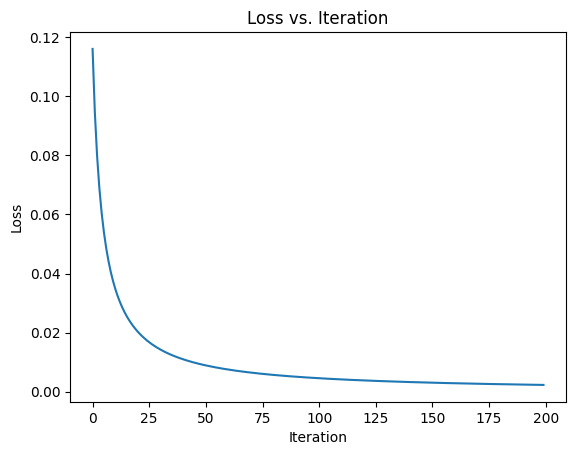

In [314]:
plot_losses(losses)

### Build same model with pyTorch 

In [315]:
import torch
import torch.nn as nn

class MLP_torch(nn.Module):
    def __init__(self):
        super(MLP_torch, self).__init__()
        self.fc1 = nn.Linear(3, 4)
        self.fc2 = nn.Linear(4, 4)
        # self.fc3 = nn.Linear(4, 4)
        self.fc4 = nn.Linear(4, 1)        

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        # x = torch.tanh(self.fc3(x))        
        x = self.fc4(x)  
        return x



model = MLP_torch()

# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5]
]

# desired targets
ys = [1.0, -1.0]

# convert to tensor
t_xs = torch.tensor(xs)

# add a dimension to the index=1 position to target tensor,
#  e.g. change size from [2] to [2, 1]
t_ys = torch.unsqueeze(torch.tensor(ys), 1)

# learning rate (i.e. step size)
learning_rate = 0.05

losses = []
for epoch in range(40):
    # forward pass
    outputs = model(t_xs)

    # calculate loss
    loss = torch.nn.functional.mse_loss(outputs, t_ys)

    # remove loss gradient 
    losses.append(loss.detach())

    # backpropagate
    loss.backward()

    # update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad.data

    # zero gradients
    for p in model.parameters():
        p.grad.data.zero_()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} loss: {loss}")

prediction = model(t_xs)
print('')
print(f"Prediction:\n{prediction.detach()}")
print(f"Loss: {loss}")


Epoch 0 loss: 0.9197540879249573
Epoch 10 loss: 0.05579092353582382
Epoch 20 loss: 0.0009356947848573327
Epoch 30 loss: 1.3890247828385327e-05

Prediction:
tensor([[ 0.9999],
        [-0.9994]])
Loss: 3.168441935486044e-07


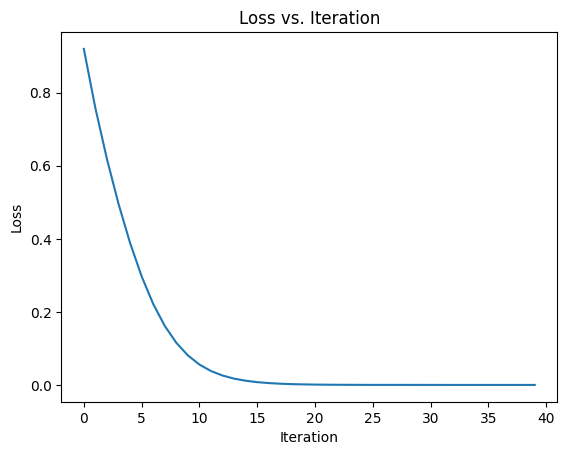

In [316]:
plot_losses(losses)

In [317]:
print(f'input xs:\n{xs}\n')
print(f'target ys:\n{ys}')
print('---------\n')
l_items = list(model.parameters())
if len(l_items) % 2 == 0:
  for i in range(0, len(l_items), 2):
    if i == 0:
      x0 = torch.clone(t_xs).detach() 
      input = torch.transpose(x0, 0, 1)
    else:
      input = output

    w = l_items[i].detach()  # remove gradient
    b_ = l_items[i + 1].detach()  # remove gradient
    b = torch.clone(b_).detach()  # remove gradient
    bT = torch.unsqueeze(b, 1)  # add a dimension to index 1 position
    w_input = torch.matmul(w, input)
    w_input_bT = torch.add(w_input, bT)

    if i == len(l_items) - 2:  # skip tanh activation on output node
      output = w_input_bT
    else:  
      output = torch.tanh(w_input_bT)      

    print(f'layer: {i / 2},  i: {i}\n')
    print(f'w,  {w.shape}:\n{w}\n')
    print(f'input,  {input.shape}:\n{input}\n')
    print(f'w * input,  {w_input.shape}:\n{w_input}\n')        
    print(f'bT,  {bT.shape}:\n{bT}\n')
    print(f'w * input + bT,  {w_input_bT.shape}:\n{w_input_bT}\n')
    print(f'output,  {output.shape}:\n{output}\n')            
    print('')
else:
  raise ValueError(f"len(l_items) {len(l_items)} is not divisible by 2.")

input xs:
[[2.0, 3.0, -1.0], [3.0, -1.0, 0.5]]

target ys:
[1.0, -1.0]
---------

layer: 0.0,  i: 0

w,  torch.Size([4, 3]):
tensor([[ 0.4240,  0.2327, -0.1169],
        [-0.5304,  0.3759,  0.2654],
        [ 0.3939, -0.6259, -0.0366],
        [ 0.0260,  0.4175,  0.0491]])

input,  torch.Size([3, 2]):
tensor([[ 2.0000,  3.0000],
        [ 3.0000, -1.0000],
        [-1.0000,  0.5000]])

w * input,  torch.Size([4, 2]):
tensor([[ 1.6630,  0.9810],
        [-0.1984, -1.8342],
        [-1.0531,  1.7894],
        [ 1.2555, -0.3150]])

bT,  torch.Size([4, 1]):
tensor([[-0.4321],
        [ 0.5416],
        [ 0.0254],
        [-0.5523]])

w * input + bT,  torch.Size([4, 2]):
tensor([[ 1.2310,  0.5489],
        [ 0.3432, -1.2926],
        [-1.0277,  1.8148],
        [ 0.7032, -0.8673]])

output,  torch.Size([4, 2]):
tensor([[ 0.8429,  0.4997],
        [ 0.3303, -0.8598],
        [-0.7730,  0.9483],
        [ 0.6064, -0.7000]])


layer: 1.0,  i: 2

w,  torch.Size([4, 4]):
tensor([[ 0.1330, -0.079

In [318]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.Size([1, 2])

In [319]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

print(output, output.shape)
print(t_ys_, t_ys_.shape)

difference = output - t_ys_
squared_difference = torch.pow(difference, 2)
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference)
loss

tensor([[ 0.9999, -0.9994]]) torch.Size([1, 2])
tensor([[ 1., -1.]]) torch.Size([1, 2])


tensor(4.1621e-07)

In [320]:
print(output, output.shape)
print(torch.tensor(ys), torch.tensor(ys).shape)

difference = output - torch.tensor(ys)
print(f'difference: {difference}')
squared_difference = torch.pow(difference, 2)
print(f'squared_difference: {squared_difference}')
# loss = torch.sum(squared_difference) / len(squared_difference)
loss = torch.sum(squared_difference) / 2
loss

tensor([[ 0.9999, -0.9994]]) torch.Size([1, 2])
tensor([ 1., -1.]) torch.Size([2])
difference: tensor([[-6.5923e-05,  6.4176e-04]])
squared_difference: tensor([[4.3458e-09, 4.1186e-07]])


tensor(2.0810e-07)

In [321]:
difference
len(squared_difference)

1

In [322]:
t_ys = torch.tensor(ys)
t_ys_ = torch.unsqueeze(t_ys, 0)
t_ys_.shape

torch.nn.functional.mse_loss(output, t_ys_)

tensor(2.0810e-07)

In [323]:
torch.sum((output - torch.tensor(ys))**2)

tensor(4.1621e-07)